In [1]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [3]:
!kaggle datasets download -d tariqsays/sentiment-dataset-with-1-million-tweets

 94% 71.0M/75.4M [00:00<00:00, 139MB/s]
100% 75.4M/75.4M [00:00<00:00, 122MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/sentiment-dataset-with-1-million-tweets.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import pandas as pd
data=pd.read_csv('/content/dataset.csv')

In [6]:
data.tail()

,Text,Language,Label
937849,@Juice_Lemons in the dark. it’s so good,en,positive
937850,8.SSR &amp; Disha Salian case should be solved...,en,negative
937851,*ACCIDENT: Damage Only* - Raleigh Fire Depart...,en,negative
937852,@reblavoie So happy for her! She’s been incred...,en,positive
937853,I'm lost and I'm found but,en,negative


In [7]:
data.describe()

,Text,Language,Label
count,937854,937831,937854
unique,929544,72,4
top,@FlylightsTech Good project,en,positive
freq,73,871310,264545


In [8]:
data['Language'].unique()

array(['en', 'es', 'ca', 'fr', 'pt', 'ja', 'hi', 'ar', 'ko', 'nl', 'et',
       'in', 'und', 'tl', 'zh', 'de', 'cs', 'ru', 'qme', 'it', 'el', 'ro',
       'no', 'tr', 'sv', 'ta', 'fa', 'ht', 'pl', 'da', 'th', 'hu', 'lv',
       'uk', 'qht', 'eu', 'qam', 'si', 'cy', 'zxx', 'ml', 'ne', 'mr',
       'qst', 'vi', 'bn', 'gu', 'is', 'fi', 'ckb', nan, 'te', 'art', 'bg',
       'ur', 'sl', 'lt', 'pa', 'iw', 'kn', 'sr',
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=large')]",
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=large')]",
       'am', 'or',
       "[Photo(previewUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=large')]",
       'sd',
       "[Photo(previewUrl='h

In [9]:
data['Label'].unique()

array(['litigious', 'negative', 'positive', 'uncertainty'], dtype=object)

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
data['Text'] = data['Text'].apply(lambda x:clean_text(x))
data

,Text,Language,Label
0,charliecorley amyklobuchar stylewriternyc tes...,en,litigious
1,badbunny como dos gotas de agua joven se disfr...,es,negative
2,flagstar bank discloses a data breach that im...,en,litigious
3,rwanda is set to host the headquarters of unit...,en,positive
4,oops i typed her name incorrectly today’s brav...,en,litigious
...,...,...,...
937849,juicelemons in the dark it’s so good,en,positive
937850,amp disha salian case should be solved amp dr...,en,negative
937851,accident damage only raleigh fire department...,en,negative
937852,reblavoie so happy for her she’s been incredible,en,positive


In [15]:
data['Language'] = data['Language'].apply(lambda x:clean_text(x))
data

,Text,Language,Label
0,charliecorley amyklobuchar stylewriternyc tes...,en,litigious
1,badbunny como dos gotas de agua joven se disfr...,es,negative
2,flagstar bank discloses a data breach that im...,en,litigious
3,rwanda is set to host the headquarters of unit...,en,positive
4,oops i typed her name incorrectly today’s brav...,en,litigious
...,...,...,...
937849,juicelemons in the dark it’s so good,en,positive
937850,amp disha salian case should be solved amp dr...,en,negative
937851,accident damage only raleigh fire department...,en,negative
937852,reblavoie so happy for her she’s been incredible,en,positive


In [16]:
data['Language'].unique()

array(['en', 'es', 'ca', 'fr', 'pt', 'ja', 'hi', 'ar', 'ko', 'nl', 'et',
       'in', 'und', 'tl', 'zh', 'de', 'cs', 'ru', 'qme', 'it', 'el', 'ro',
       'no', 'tr', 'sv', 'ta', 'fa', 'ht', 'pl', 'da', 'th', 'hu', 'lv',
       'uk', 'qht', 'eu', 'qam', 'si', 'cy', 'zxx', 'ml', 'ne', 'mr',
       'qst', 'vi', 'bn', 'gu', 'is', 'fi', 'ckb', 'nan', 'te', 'art',
       'bg', 'ur', 'sl', 'lt', 'pa', 'iw', 'kn', 'sr', '', 'am', 'or',
       'sd', '  '], dtype=object)

In [17]:
def remove_stopword(text):
    if pd.notnull(text):
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        filtered_text = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_text)
    return text

In [18]:
def lemmatize_text(text):
    if pd.notnull(text):
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        lemmatized_text = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(lemmatized_text)
    return text

In [19]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [20]:
data['Text'] = data['Text'].apply(lambda x: remove_stopword(x))
data['Text'] = data['Text'].apply(lambda x: lemmatize_text(x))

In [21]:
data['Text']

0         charliecorley amyklobuchar stylewriternyc test...
1         badbunny como do gotas de agua joven se disfra...
2         flagstar bank discloses data breach impacted i...
3         rwanda set host headquarters united nation dev...
4         oops typed name incorrectly today ’ brave witn...
                                ...                        
937849                              juicelemons dark ’ good
937850    amp disha salian case solved amp drug cartel f...
937851    accident damage raleigh fire department fairwa...
937852                         reblavoie happy ’ incredible
937853                                     im lost im found
Name: Text, Length: 937854, dtype: object

In [22]:
data

,Text,Language,Label
0,charliecorley amyklobuchar stylewriternyc test...,en,litigious
1,badbunny como do gotas de agua joven se disfra...,es,negative
2,flagstar bank discloses data breach impacted i...,en,litigious
3,rwanda set host headquarters united nation dev...,en,positive
4,oops typed name incorrectly today ’ brave witn...,en,litigious
...,...,...,...
937849,juicelemons dark ’ good,en,positive
937850,amp disha salian case solved amp drug cartel f...,en,negative
937851,accident damage raleigh fire department fairwa...,en,negative
937852,reblavoie happy ’ incredible,en,positive


In [23]:
# Separate the features (tweets) and labels (language and sentiment)
tweets = data['Text']
language_labels = data['Language']
sentiment_labels = data['Label']
# Split the dataset into training and testing sets
tweets_train, tweets_test, lang_labels_train, lang_labels_test, sent_labels_train, sent_labels_test = train_test_split(
    tweets, language_labels, sentiment_labels, test_size=0.2, random_state=42
)

In [24]:
tweets_train

386279                                    afcgabeast flawed
620990    kareemgomjabbar megamohsi loathethyself ap ien...
671823    margotdehainaut lumisanthrope rien qui ne soit...
826639       reimuh good morning reimuhsan☀️ good wednesday
812990    thrivecas att tim best even ’ twitter handle t...
                                ...                        
259178    might well ranting account lot rant tweet 💀 lo...
365838    📺 виступ володимира зеленського на засіданні р...
131932                                          share dream
671155    tabsiraproject dr ilyas bayunas havent heard n...
121958    lang hahahahahasame sound bawal na ba sumabay ...
Name: Text, Length: 750283, dtype: object

In [25]:
lang_labels_train

386279    en
620990    en
671823    fr
826639    en
812990    en
          ..
259178    en
365838    uk
131932    en
671155    en
121958    tl
Name: Language, Length: 750283, dtype: object

In [26]:
sent_labels_train

386279       negative
620990       negative
671823       negative
826639       positive
812990       positive
             ...     
259178    uncertainty
365838      litigious
131932       positive
671155       negative
121958       positive
Name: Label, Length: 750283, dtype: object

In [27]:
# Define the pipeline for language identification
language_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

# Train the language identification model
language_pipeline.fit(tweets_train, lang_labels_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [28]:
from sklearn.naive_bayes import MultinomialNB

# Define the pipeline for sentiment classification
sentiment_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Train the sentiment classification model
sentiment_pipeline.fit(tweets_train, sent_labels_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [52]:
# Predict the language of a tweet
tweet = "it is boring day"
predicted_language = language_pipeline.predict([tweet])[0]
print("Predicted language:", predicted_language)

Predicted language: en


In [60]:
# Predict the sentiment of a tweet
tweet = "what a song"
predicted_sentiment = sentiment_pipeline.predict([tweet])[0]
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: positive


In [31]:
# Evaluate the language identification model
lang_predictions = language_pipeline.predict(tweets_test)
lang_report = classification_report(lang_labels_test, lang_predictions)
print("Language identification report:\n", lang_report)

# Evaluate the sentiment classification model
sent_predictions = sentiment_pipeline.predict(tweets_test)
sent_report = classification_report(sent_labels_test, sent_predictions)
print("Sentiment classification report:\n", sent_report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Language identification report:
               precision    recall  f1-score   support

                   0.00      0.00      0.00         1
          am       0.00      0.00      0.00         2
          ar       0.94      0.77      0.85       158
         art       0.00      0.00      0.00        10
          bn       1.00      0.50      0.67         2
          ca       0.94      0.66      0.77       174
          cs       1.00      0.53      0.69        34
          cy       1.00      0.16      0.27        19
          da       0.82      0.30      0.44        30
          de       0.98      0.87      0.92       405
          el       0.88      0.70      0.78        10
          en       0.98      1.00      0.99    174375
          es       0.94      0.91      0.92      2313
          et       0.52      0.10      0.16       124
          eu       0.29      0.11      0.15        19
          fa       0.86      0.88      0.87        48
          fi       1.00      0.29      0.44     

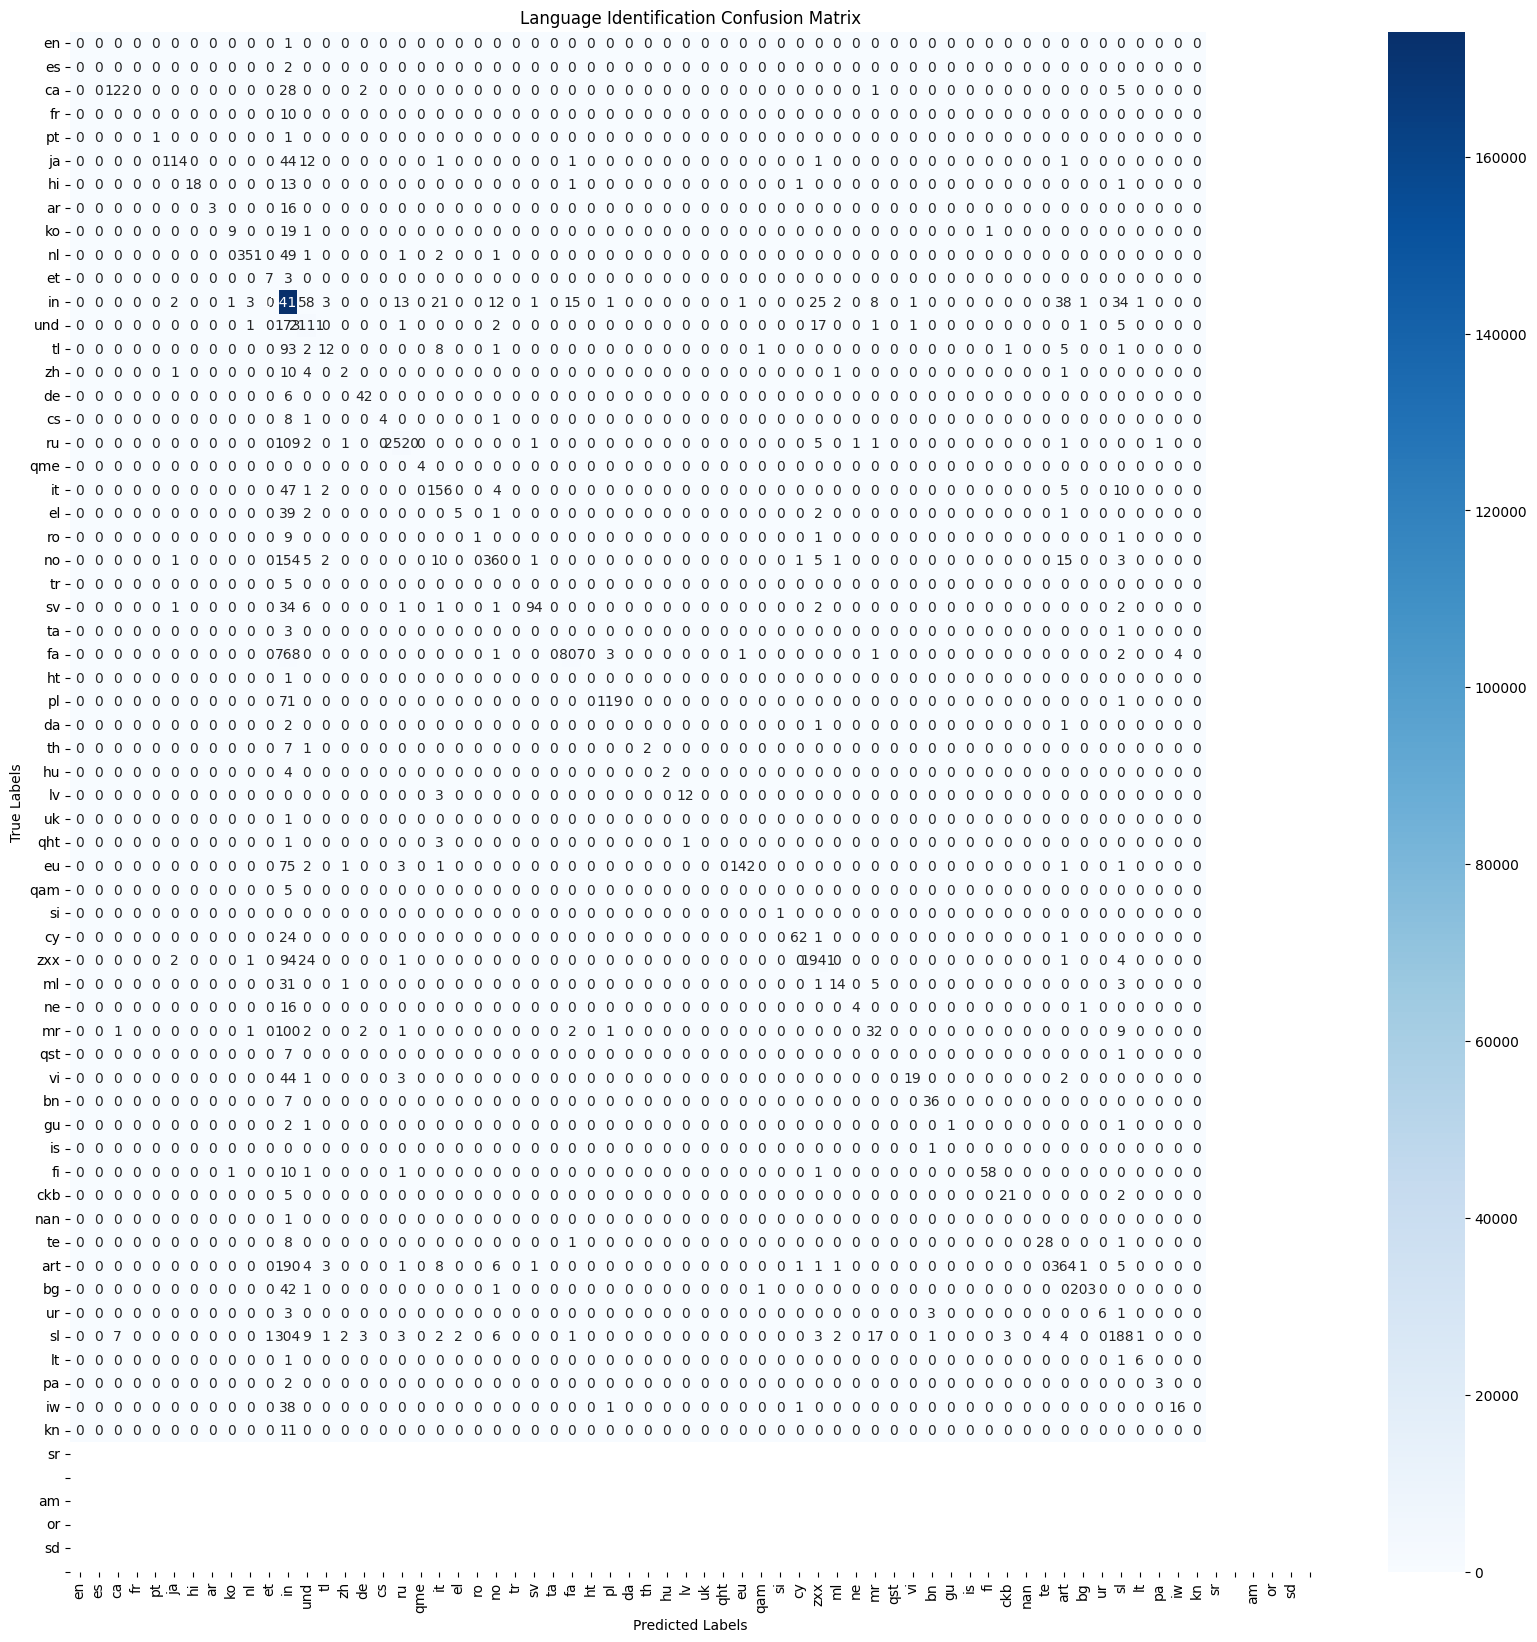

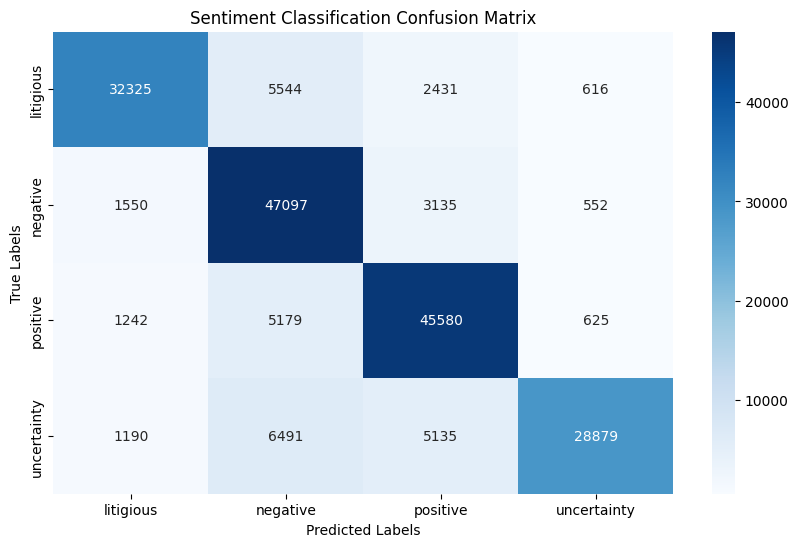

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Language Identification Confusion Matrix
language_classes=data['Language'].unique()
lang_cm = confusion_matrix(lang_labels_test, lang_predictions)
plt.figure(figsize=(20, 20))
sns.heatmap(lang_cm, annot=True, fmt="d", cmap="Blues", xticklabels=language_classes, yticklabels=language_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Language Identification Confusion Matrix')
plt.show()

# Sentiment Classification Confusion Matrix
sentiment_classes=data['Label'].unique()
sent_cm = confusion_matrix(sent_labels_test, sent_predictions)
plt.figure(figsize=(10, 6))
sns.heatmap(sent_cm, annot=True, fmt="d", cmap="Blues", xticklabels=sentiment_classes, yticklabels=sentiment_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Sentiment Classification Confusion Matrix')
plt.show()


In [33]:
from sklearn.metrics import classification_report

# Language Identification Classification Report
lang_report = classification_report(lang_labels_test, lang_predictions, labels=language_classes)
print("Language Identification Classification Report:\n", lang_report)

# Sentiment Classification Classification Report
sent_report = classification_report(sent_labels_test, sent_predictions, labels=sentiment_classes)
print("Sentiment Classification Classification Report:\n", sent_report)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Language Identification Classification Report:
               precision    recall  f1-score   support

          en       0.98      1.00      0.99    174375
          es       0.94      0.91      0.92      2313
          ca       0.94      0.66      0.77       174
          fr       0.99      0.95      0.97      2642
          pt       0.97      0.94      0.95      2068
          ja       0.97      0.51      0.67      1587
          hi       0.72      0.69      0.71       225
          ar       0.94      0.77      0.85       158
          ko       0.95      0.62      0.75       191
          nl       0.99      0.63      0.77       226
          et       0.52      0.10      0.16       124
          in       0.91      0.65      0.75       558
         und       0.66      0.33      0.44       564
          tl       0.83      0.62      0.71       586
          zh       0.80      0.29      0.42        56
          de       0.98      0.87      0.92       405
          cs       1.00      0.53